(muth_kalman)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

```{index} single: python
```

# Reverse Engineering a la Muth

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture uses the quantecon library.

In [1]:
!pip install --upgrade quantecon

We'll also need the following imports:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.linalg as la

from quantecon import Kalman
from quantecon import LinearStateSpace
from scipy.stats import norm
np.set_printoptions(linewidth=120, precision=4, suppress=True)

This lecture uses the Kalman filter to reformulate John F. Muth’s first
paper {cite}`Muth1960` about rational expectations.

Muth used *classical* prediction methods to reverse engineer a
stochastic process that renders optimal Milton Friedman’s {cite}`Friedman1956` “adaptive
expectations” scheme.

## Friedman (1956) and Muth (1960)

Milton Friedman {cite}`Friedman1956` (1956) posited that
consumer’s forecast their future disposable income with the adaptive
expectations scheme

```{math}
:label: expectations

y_{t+i,t}^* = K \sum_{j=0}^\infty (1 - K)^j y_{t-j}
```

where $K \in (0,1)$ and $y_{t+i,t}^*$ is a forecast of
future $y$ over horizon $i$.

Milton Friedman justified the **exponential smoothing** forecasting
scheme {eq}`expectations` informally, noting  that it seemed a plausible way to use
past income to forecast future income.

In his first paper about rational expectations, John F. Muth {cite}`Muth1960`
reverse-engineered a univariate stochastic process
$\{y_t\}_{t=- \infty}^\infty$ for which Milton Friedman’s adaptive
expectations scheme gives linear least forecasts of $y_{t+j}$ for
any horizon $i$.

Muth sought a setting and a sense in which Friedman’s forecasting scheme
is optimal.

That is, Muth asked for what optimal forecasting **question** is Milton
Friedman’s adaptive expectation scheme the **answer**.

Muth (1960) used classical prediction methods based on lag-operators and
$z$-transforms to find the answer to his question.

Please see lectures {doc}`Classical Control with Linear Algebra <lu_tricks>` and
{doc}`Classical Filtering and Prediction with Linear Algebra <classical_filtering>` for an introduction to the classical
tools that Muth used.

Rather than using those classical tools, in this lecture we apply the
Kalman filter to express the heart of Muth’s analysis concisely.

The lecture [First Look at Kalman Filter](https://python-intro.quantecon.org/kalman.html) describes the Kalman filter.

We'll use limiting versions of the Kalman filter corresponding to what are called **stationary values** in that lecture.

## A Process for Which Adaptive Expectations are Optimal

Suppose that an observable $y_t$ is the sum of an unobserved
random walk $x_t$ and an IID shock $\epsilon_{2,t}$:

```{math}
:label: state-space

\begin{aligned} x_{t+1} & = x_t + \sigma_x \epsilon_{1,t+1} \cr
          y_t & = x_t + \sigma_y \epsilon_{2,t} \end{aligned}
```

where

$$
\begin{bmatrix} \epsilon_{1,t+1} \cr \epsilon_{2,t} \end{bmatrix} \sim {\mathcal N} (0, I)
$$

is an IID process.

**Note:** A property of the state-space representation {eq}`state-space` is that in
general neither $\epsilon_{1,t}$ nor $\epsilon_{2,t}$ is in
the space spanned by square-summable linear combinations of
$y_t, y_{t-1}, \ldots$.

In general
$\begin{bmatrix} \epsilon_{1,t} \cr \epsilon_{2t} \end{bmatrix}$
has more information about future $y_{t+j}$’s than is contained
in $y_t, y_{t-1}, \ldots$.

We can use the asymptotic or stationary values of the Kalman gain and
the one-step-ahead conditional state covariance matrix to compute a
time-invariant *innovations representation*

```{math}
:label: innovations

\begin{aligned} \hat x_{t+1} & = \hat x_t + K a_t  \cr
           y_t & = \hat x_t + a_t \end{aligned}
```

where $\hat x_t = E [x_t | y_{t-1}, y_{t-2}, \ldots ]$ and
$a_t = y_t - E[y_t |y_{t-1}, y_{t-2}, \ldots ]$.

**Note:** A key property about an *innovations representation* is that
$a_t$ is in the space spanned by square summable linear
combinations of $y_t, y_{t-1}, \ldots$.

For more ramifications of this property, see the lectures  {doc}`Shock Non-Invertibility <hs_invertibility_example>`  and
{doc}`Recursive Models of Dynamic Linear Economies <hs_recursive_models>`.

Later we’ll stack these state-space systems {eq}`state-space` and {eq}`innovations` to display some
classic findings of Muth.

But first, let’s create an instance of the state-space system {eq}`state-space` then
apply the quantecon `Kalman` class, then uses it to construct the associated "innovations representation"

In [3]:
# Make some parameter choices
# sigx/sigy are state noise std err and measurement noise std err
μ_0, σ_x, σ_y = 10, 1, 5

# Create a LinearStateSpace object
A, C, G, H = 1, σ_x, 1, σ_y
ss = LinearStateSpace(A, C, G, H, mu_0=μ_0)

# Set prior and initialize the Kalman type
x_hat_0, Σ_0 = 10, 1
kmuth = Kalman(ss, x_hat_0, Σ_0)

# Computes stationary values which we need for the innovation
# representation
S1, K1 = kmuth.stationary_values()

# Extract scalars from nested arrays
S1, K1 = S1.item(), K1.item()

# Form innovation representation state-space
Ak, Ck, Gk, Hk = A, K1, G, 1

ssk = LinearStateSpace(Ak, Ck, Gk, Hk, mu_0=x_hat_0)

## Some Useful State-Space Math

Now we want to map the time-invariant innovations representation {eq}`innovations` and
the original state-space system {eq}`state-space` into a convenient form for deducing
the impulse responses from the original shocks to the $x_t$ and
$\hat x_t$.

Putting both of these representations into a single state-space system
is yet another application of the insight that “finding the state is an
art”.

We’ll define a state vector and appropriate state-space matrices that
allow us to represent both systems in one fell swoop.

Note that

$$
a_t = x_t + \sigma_y \epsilon_{2,t} - \hat x_t
$$

so that

$$
\begin{aligned} \hat x_{t+1} & = \hat x_t + K (x_t + \sigma_y \epsilon_{2,t} - \hat x_t) \cr
       & = (1-K) \hat x_t + K x_t + K \sigma_y \epsilon_{2,t} \end{aligned}
$$

The stacked system

$$
\begin{bmatrix} x_{t+1} \cr \hat x_{t+1} \cr \epsilon_{2,t+1} \end{bmatrix} =
\begin{bmatrix} 1 & 0 & 0 \cr K & (1-K) & K \sigma_y \cr 0 & 0 & 0 \end{bmatrix}
\begin{bmatrix} x_{t} \cr \hat x_t \cr \epsilon_{2,t} \end{bmatrix}+
\begin{bmatrix} \sigma_x & 0 \cr 0 & 0 \cr 0 & 1 \end{bmatrix}
\begin{bmatrix} \epsilon_{1,t+1} \cr \epsilon_{2,t+1} \end{bmatrix}
$$

$$
\begin{bmatrix} y_t \cr a_t \end{bmatrix} = \begin{bmatrix} 1 & 0 & \sigma_y \cr
                                      1 & -1 & \sigma_y \end{bmatrix}  \begin{bmatrix} x_{t} \cr \hat x_t \cr \epsilon_{2,t} \end{bmatrix}
$$

is a state-space system that tells us how the shocks
$\begin{bmatrix} \epsilon_{1,t+1} \cr \epsilon_{2,t+1} \end{bmatrix}$
affect states $\hat x_{t+1}, x_t$, the observable $y_t$, and
the innovation $a_t$.

With this tool at our disposal, let’s form the composite system and
simulate it

In [4]:
# Create grand state-space for y_t, a_t as observed vars -- Use
# stacking trick above
Af = np.array([[ 1,      0,        0],
               [K1, 1 - K1, K1 * σ_y],
               [ 0,      0,        0]])
Cf = np.array([[σ_x,        0],
               [  0, K1 * σ_y],
               [  0,        1]])
Gf = np.array([[1,  0, σ_y],
               [1, -1, σ_y]])

μ_true, μ_prior = 10, 10
μ_f = np.array([μ_true, μ_prior, 0]).reshape(3, 1)

# Create the state-space
ssf = LinearStateSpace(Af, Cf, Gf, mu_0=μ_f)

# Draw observations of y from the state-space model
N = 50
xf, yf = ssf.simulate(N)

print(f"Kalman gain = {K1}")
print(f"Conditional variance = {S1}")

Kalman gain = 0.1809975124224177
Conditional variance = 5.524937810560442


Now that we have simulated our joint system, we have $x_t$,
$\hat{x_t}$, and $y_t$.

We can now investigate how these
variables are related by plotting some key objects.

## Estimates of Unobservables

First, let’s plot the hidden state $x_t$ and the filtered version
$\hat x_t$ that is linear-least squares projection of $x_t$
on the history $y_{t-1}, y_{t-2}, \ldots$

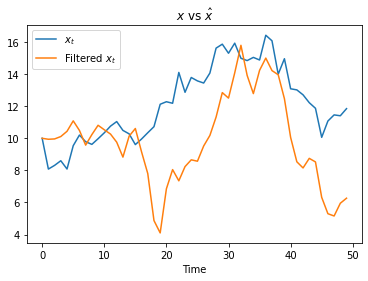

In [5]:
fig, ax = plt.subplots()
ax.plot(xf[0, :], label="$x_t$")
ax.plot(xf[1, :], label="Filtered $x_t$")
ax.legend()
ax.set_xlabel("Time")
ax.set_title(r"$x$ vs $\hat{x}$")
plt.show()

Note how $x_t$ and $\hat{x_t}$ differ.

For Friedman, $\hat x_t$ and not $x_t$ is the consumer’s
idea about her/his *permanent income*.

## Relationship of Unobservables to Observables

Now let’s plot $x_t$ and $y_t$.

Recall that $y_t$ is just $x_t$ plus white noise

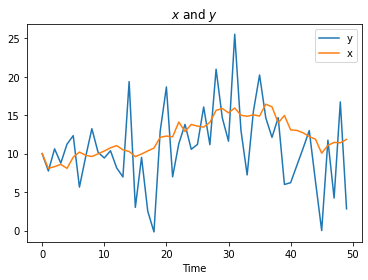

In [6]:
fig, ax = plt.subplots()
ax.plot(yf[0, :], label="y")
ax.plot(xf[0, :], label="x")
ax.legend()
ax.set_title(r"$x$ and $y$")
ax.set_xlabel("Time")
plt.show()

We see above that $y$ seems to look like white noise around the
values of $x$.

### Innovations

Recall that we wrote down the innovation representation that depended on
$a_t$. We now plot the innovations $\{a_t\}$:

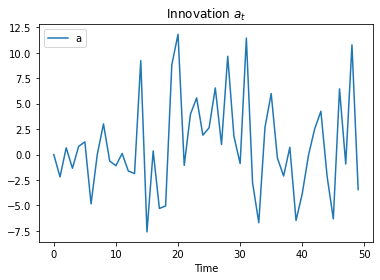

In [7]:
fig, ax = plt.subplots()
ax.plot(yf[1, :], label="a")
ax.legend()
ax.set_title(r"Innovation $a_t$")
ax.set_xlabel("Time")
plt.show()

## MA and AR Representations

Now we shall extract from the `Kalman` instance `kmuth` coefficients of

- a fundamental moving average representation that represents
  $y_t$ as a one-sided moving sum of current and past
  $a_t$s that are square summable linear combinations of $y_t, y_{t-1}, \ldots$.
- a univariate autoregression representation that depicts the
  coefficients in a linear least square projection of $y_t$ on
  the semi-infinite history $y_{t-1}, y_{t-2}, \ldots$.

Then we’ll plot each of them

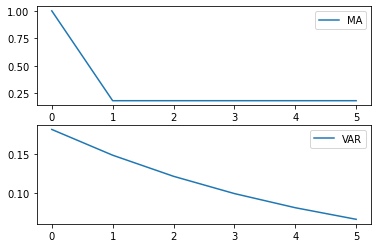

In [8]:
# Kalman Methods for MA and VAR
coefs_ma = kmuth.stationary_coefficients(5, "ma")
coefs_var = kmuth.stationary_coefficients(5, "var")

# Coefficients come in a list of arrays, but we
# want to plot them and so need to stack into an array
coefs_ma_array = np.vstack(coefs_ma)
coefs_var_array = np.vstack(coefs_var)

fig, ax = plt.subplots(2)
ax[0].plot(coefs_ma_array, label="MA")
ax[0].legend()
ax[1].plot(coefs_var_array, label="VAR")
ax[1].legend()

plt.show()

The **moving average** coefficients in the top panel show tell-tale
signs of $y_t$ being a process whose first difference is a first-order
autoregression.

The **autoregressive coefficients** decline geometrically with decay
rate $(1-K)$.

These are exactly the target outcomes that Muth (1960) aimed to reverse
engineer

In [9]:
print(f'decay parameter 1 - K1 = {1 - K1}')

decay parameter 1 - K1 = 0.8190024875775823
